# Penny-shaped crack under remote uniform tension - axisymmetric mode I crack problem

Axisymmetric problem 
Straight penny-shaped fracture in an infinite isotropic elastic medium  under uniform remote tension

Note - the Axi3DP0 kernel assumes a zero Poisson's ratio ! as it is coded up also for circular shear ruptures with a unique slip direction (Salamon & Dundurs, 1971, 1977).

In [7]:
# imports etc.
import sys
import os
home = os.environ["HOME"]
sys.path.append("/Users/bricelecampion/ClionProjects/BigWham_dev/build/interfaces/python")
from hmatrix import Hmatrix
import numpy as np
from scipy.sparse.linalg import gmres

sys.path.append(os.path.join(os.getcwd(), '../..'))
from solutions.penny_shaped_crack import *
import matplotlib.pyplot as plt


We set the elastic properties of the medium. Note that bigwham's input are the Young's modulus $E$ and Poisson's ratio $\nu$.

In [8]:
G = 1.0
nu = 0.
E = (2 * G) * (1 + nu)

We define a function in order to solve the problem with a given number of elements. Either for P0 elements (constant displacement interpolation) or P1 elements (linear interpolation over the element but discontinuous between element).

In [13]:
def solvePennyShapedUniform(nelts,a=1,kernel = "Axi3DP0"):
    """Wrapper function to solve the penny-shaped problem with a given number of elements + element type"""
    coor1D = np.linspace(0, a, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)
    # H-matrix parameters - choosen here to have an accurate solution
    max_leaf_size=100
    eta=2.
    eps_aca=1.e-5
    elas_prop = np.array([E, nu])
    h = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)
    t = np.ones(h.shape[0])
    t[0::2] = 0.
    jac_ilu= h.H_ILU_prec() # we use a ilu precond 
    d = gmres(h, t,M=jac_ilu,tol=1e-6)[0]
    dd = d.reshape((-1, 2))
    col_pts = h.getMeshCollocationPoints()
    r_coor_=col_pts[:,0]
    # Crack opening displacement discontinuity from analytical solution 
    w_true=width(r_coor_,R=1,sig=1,G=1,nu=0.)
    rmse = np.sqrt((np.sum(dd[:,1]-w_true)**2)/(w_true.size))
    l2rel = (np.linalg.norm((dd[:,1]-w_true)))/(np.linalg.norm(w_true))
    return r_coor_,dd,w_true,rmse,l2rel 

0.02052080351190538


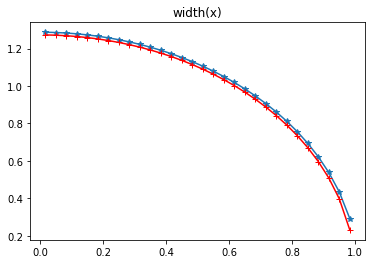

In [23]:
xcorr,dd_sol,w_true,rmse,l2rel = solvePennyShapedUniform(30,a=1,kernel="Axi3DP0")

plt.plot(xcorr, dd_sol[:,1], "-*")
plt.plot(xcorr, w_true, "-+r") 
plt.title('width(x)')
print(l2rel)

Now, let's perform the same numerical simulation for different number of elements. We go from 10 elements to 10'000. We compute the "approximate" rate of convergence of both the rmse and l2 relative error.
Note that the RMSE and relative L2 norm are defined respetively as
 $$rmse = \sqrt{\sum_{i=1,N} (num_i - true_i)^2/N} $$
 and
 $$L_{2 rel} = \frac{\||  \mathbf{num} - \mathbf{true} \||_2}{\|| \mathbf{true} \||_2}$$
  such that the rate of convergence of the rmse is about 1/2 of the one of the L2.

To esitmate the rate of convernce of an error metric $e$, we compute:
$$ \beta = \log{(e_2/e_1)}/\log{(N_1/N_2)} $$

where $e_1$ is the error for $N_1$ unknowns, respectively for $e_2$ (with $N_2<N_1$). 

In [18]:
list_nelts=np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rmse =[]
l2_rel = []
for n in list_nelts:
    col_pts,dd_sol,wtr,rmse_n,lerel_n = solvePennyShapedUniform(n,a=1,kernel="Axi3DP0")
    w_true=width(col_pts,R=1,sig=1,G=1,nu=0.)
    rmse.append(rmse_n)
    l2_rel.append(lerel_n)
    
# computing the rate of convergence
beta_rmse = [1 * np.log(rmse[i]/rmse[i-1])/np.log(list_nelts[i-1]/list_nelts[i]) for i in range(2,list_nelts.size-1)]
beta_l2 = [1 * np.log(l2_rel[i]/l2_rel[i-1])/np.log(list_nelts[i-1]/list_nelts[i]) for i in range(2,list_nelts.size-1)]

In [17]:
col_pts[:]

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

0.4946714739117189


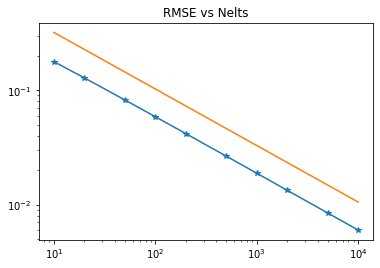

In [19]:
plt.loglog(list_nelts, rmse, "-*")
plt.loglog(list_nelts, 1/list_nelts**np.median(beta_rmse), "-")
plt.title('RMSE vs Nelts')
print(np.median(beta_rmse))
# rmese defined as  sqrt(1/Nelts Sum  (num_i-true_i)^2)

0.9522044027437631


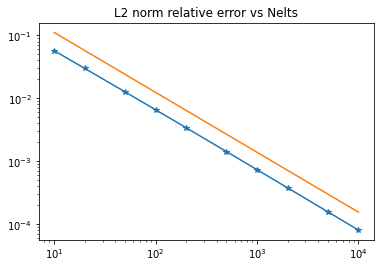

In [20]:
plt.loglog(list_nelts, l2_rel, "-*")
plt.loglog(list_nelts, 1/list_nelts**np.median(beta_l2), "-")
plt.title('L2 norm relative error vs Nelts')
# L2 norm relative defined as ||num_i - true_i||_2 / ||true_i||
print(np.median(beta_l2))
